# Importing Libraries


In [1]:
import sys
#import pycats
import datetime
import os
import glob
import time
import csv
import numpy as np
import pandas as pd
import pyhive
from pyhive import hive
from datetime import datetime
from pandas.api.types import is_string_dtype, is_numeric_dtype
from scipy.stats import boxcox, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Importing data from hive

In [2]:
conn = hive.connect(host='dbslp0500', port= 10002, auth='LDAP', username="hattri10", password="Him<8349")
stat = """set mapreduce.job.queuename= araadh_q1.ararest_sq1"""
stat1="""select * from mcr_eni_redev.train_2018_mar2019"""
stat1=stat1.replace("\n"," ")
stat1=stat1.replace('\t'," ")
stat1=stat1.replace("   "," ")
cur = conn.cursor()
start=time.time()
print(start)
cur = conn.cursor()
cur.execute(stat)
cur.execute(stat1)
MCR_Inscope= pd.DataFrame(cur.fetchall())
MCR_Inscope.columns = ['key','clm_10','fst_srvc_dt','proc_cd_gal','npi','prov_tin','src_chrg_amt','bth_dt','st_abbr_cd','srvc_prov_catgy_cd','bil_recv_dt','proc_cat','proc_sub_cat','den_flag_mcr','prop_billed_exceed_med','cpt_variation_tagging','service_billed_dur','mem_age','diag_cat','prov_hist_same_03','prov_hist_same_03_prop','prov_hist_same_06','prov_hist_same_06_prop','prov_hist_same_09','prov_hist_same_09_prop','catgy_rol_up_1_desc','catgy_rol_up_2_desc','catgy_rol_up_3_desc','catgy_rol_up_4_desc','prov_catgy_desc','prov_spcl_catgy_desc','ahrq_proc_genl_catgy_desc','prov_spcl_catgy_cd']
print("done")

1563446481.5747335
done


In [3]:
MCR_Inscope_train=MCR_Inscope.copy()
MCR_Inscope_train.head()
#MCR_Inscope_train.to_csv("/mapr/projects/MCR_Threshold/Data/Inscope_develpmnt.csv",index=False)

,key,clm_10,fst_srvc_dt,proc_cd_gal,npi,prov_tin,src_chrg_amt,bth_dt,st_abbr_cd,srvc_prov_catgy_cd,...,prov_hist_same_09,prov_hist_same_09_prop,catgy_rol_up_1_desc,catgy_rol_up_2_desc,catgy_rol_up_3_desc,catgy_rol_up_4_desc,prov_catgy_desc,prov_spcl_catgy_desc,ahrq_proc_genl_catgy_desc,prov_spcl_catgy_cd
0,332864113401-1-55899-2017-12-28,3328641134,2017-12-28,55899,1053346064,620858347,4000.0,1955-09-02,ME,0996,...,0,0.0,UROLOGY ...,SPECIALIST,PHYSICIAN,PROFESSIONAL,UROLOGIST ...,UROLOGIST ...,OPER MALE GENITAL ORGANS,19
1,332864376401-1-69799-2017-12-22,3328643764,2017-12-22,69799,1730126392,391127163,4326.0,1985-10-12,ME,0110,...,0,0.0,CHIROPRACTOR ...,CHIROPRACTOR,ALLIED HEALTH PROVIDER,PROFESSIONAL,CHIROPRACTOR ...,OTOLARYNGOLOGIST ...,OPERATIONS EAR,10
2,332864376401-2-69799-2017-12-22,3328643764,2017-12-22,69799,1730126392,391127163,2163.0,1985-10-12,ME,0110,...,0,0.0,CHIROPRACTOR ...,CHIROPRACTOR,ALLIED HEALTH PROVIDER,PROFESSIONAL,CHIROPRACTOR ...,OTOLARYNGOLOGIST ...,OPERATIONS EAR,10
3,332864379401-6-29999-2017-12-18,3328643794,2017-12-18,29999,1417953787,911352993,1129.0,1989-08-14,ME,4858,...,0,0.0,PODIATRIST - NON-MD ...,PODIATRIST - NON-MD,ALLIED HEALTH PROVIDER,PROFESSIONAL,PODIATRIST - NON-MD (BOARD CERTIFIED) ...,PODIATRIST/MD ...,OPER MUSCULOSKELETAL SYS,26
4,332917349201-3-29999-2017-12-21,3329173492,2017-12-21,29999,1699765107,752507791,2200.0,1990-07-23,ME,0644,...,0,NaN,ORTHOPEDICS ...,SPECIALIST,PHYSICIAN,PROFESSIONAL,ORTHOPEDIC SURGEON ...,ORTHOPEDIST ...,OPER MUSCULOSKELETAL SYS,9


In [5]:
MCR_Inscope_train.proc_sub_cat.value_counts()

surgical    28602
others      25002
Name: proc_sub_cat, dtype: int64

In [13]:
MCR_Inscope_All=MCR_Inscope.copy()
MCR_Inscope_All.drop_duplicates(inplace=True)
MCR_Inscope_All.drop(['npi','bth_dt'], axis=1, inplace=True)
MCR_Inscope_All.reset_index()
print (MCR_Inscope.shape,MCR_Inscope_All.shape)

MCR_Inscope_All.head(2)

((53604, 33), (53604, 31))


,key,clm_10,fst_srvc_dt,proc_cd_gal,prov_tin,src_chrg_amt,st_abbr_cd,srvc_prov_catgy_cd,bil_recv_dt,proc_cat,...,prov_hist_same_09,prov_hist_same_09_prop,catgy_rol_up_1_desc,catgy_rol_up_2_desc,catgy_rol_up_3_desc,catgy_rol_up_4_desc,prov_catgy_desc,prov_spcl_catgy_desc,ahrq_proc_genl_catgy_desc,prov_spcl_catgy_cd
0,332864113401-1-55899-2017-12-28,3328641134,2017-12-28,55899,620858347,4000.0,ME,0996,2018-01-02,Unlisted,...,0,0.0,UROLOGY ...,SPECIALIST,PHYSICIAN,PROFESSIONAL,UROLOGIST ...,UROLOGIST ...,OPER MALE GENITAL ORGANS,19
1,332864376401-1-69799-2017-12-22,3328643764,2017-12-22,69799,391127163,4326.0,ME,0110,2018-01-02,Unlisted,...,0,0.0,CHIROPRACTOR ...,CHIROPRACTOR,ALLIED HEALTH PROVIDER,PROFESSIONAL,CHIROPRACTOR ...,OTOLARYNGOLOGIST ...,OPERATIONS EAR,10


In [14]:
# strip (whitespaces) all object dtypes
df_obj = MCR_Inscope_All.select_dtypes(['object'])
df_obj
MCR_Inscope_All[df_obj.columns] = df_obj.apply(lambda x: x.str.strip()).replace('', np.nan)
del [[df_obj]];df_obj = pd.DataFrame();

In [15]:
#Dates {infer_datetime_format=True}
#MCR_Inscope_All['fst_srvc_dt']=MCR_Inscope_All['fst_srvc_dt'].astype(str).str.strip()
MCR_Inscope_All['fst_srvc_dt']=pd.to_datetime(MCR_Inscope_All['fst_srvc_dt'], format = "%Y-%m-%d")
#MCR_Inscope_All['lst_srvc_dt']=pd.to_datetime(MCR_Inscope_All['lst_srvc_dt'], format = "%Y-%m-%d")
MCR_Inscope_All['bil_recv_dt']=pd.to_datetime(MCR_Inscope_All['bil_recv_dt'], format = "%Y-%m-%d")
MCR_Inscope_All['cpt_variation_tagging']=MCR_Inscope_All['cpt_variation_tagging'].astype(str)
#MCR_Inscope_All['den_flag_mcr']=MCR_Inscope_All['den_flag_mcr'].astype(str)


In [16]:
## inorder to use it in test

MCR_Inscope_All_use=MCR_Inscope_All.copy()

# Pre-processing of data

In [17]:
#missing value imputation (Mode)
cols_cat = ['prov_spcl_catgy_cd','st_abbr_cd','srvc_prov_catgy_cd','catgy_rol_up_1_desc','catgy_rol_up_2_desc','catgy_rol_up_3_desc','catgy_rol_up_4_desc','prov_catgy_desc','prov_spcl_catgy_desc','diag_cat','ahrq_proc_genl_catgy_desc']

MCR_Inscope_All[cols_cat]=MCR_Inscope_All[cols_cat].fillna(MCR_Inscope_All.mode().iloc[0])


In [18]:
#missing value imputation (median)
#df.apply(lambda x: x.fillna(x.mean()),axis=0)
cols_conti1 = ['prov_hist_same_06','prov_hist_same_09','prov_hist_same_03','service_billed_dur','mem_age','prop_billed_exceed_med']
cols_conti2=['prov_hist_same_06_prop','prov_hist_same_09_prop','prov_hist_same_03_prop']

MCR_Inscope_All[cols_conti1]=MCR_Inscope_All[cols_conti1].fillna((MCR_Inscope_All[cols_conti1].median()))

#MCR_Inscope_All[cols_conti2]=MCR_Inscope_All[cols_conti2].fillna((0))




In [19]:
#Outlier Treatment
MCR_Inscope_All["mem_age"] = np.where(MCR_Inscope_All["mem_age"] < 0,MCR_Inscope_All['mem_age'].median(),np.where(MCR_Inscope_All['mem_age'] == 0,1,MCR_Inscope_All['mem_age']))
MCR_Inscope_All['service_billed_dur'] = np.where(MCR_Inscope_All['service_billed_dur'] < 0,MCR_Inscope_All['service_billed_dur'].median(),MCR_Inscope_All['service_billed_dur'])
###bucketing for service billed duration 90-180 , above 180 

q90_03=MCR_Inscope_All['prov_hist_same_03'].quantile(0.90)
MCR_Inscope_All['prov_hist_same_03'] = np.where(MCR_Inscope_All['prov_hist_same_03'] > q90_03, q90_03, MCR_Inscope_All['prov_hist_same_03'])

q90_06=MCR_Inscope_All['prov_hist_same_06'].quantile(0.90)
MCR_Inscope_All['prov_hist_same_06'] = np.where(MCR_Inscope_All['prov_hist_same_06'] > q90_06, q90_06, MCR_Inscope_All['prov_hist_same_06'])

q90_09=MCR_Inscope_All['prov_hist_same_09'].quantile(0.90)
MCR_Inscope_All['prov_hist_same_09'] = np.where(MCR_Inscope_All['prov_hist_same_09'] > q90_09, q90_09, MCR_Inscope_All['prov_hist_same_09'])                                        

In [20]:
# Variable Bucketization
# a.Categorical variables

MCR_Inscope_den = MCR_Inscope_All[MCR_Inscope_All['den_flag_mcr'] == 1]

## 1.Diagnosis code category

MCR_Inscope_den_diag=MCR_Inscope_den.groupby('diag_cat',as_index=False).agg({"clm_10":"count"})
df_2 = MCR_Inscope_den_diag.sort_values(by="clm_10",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)
df_2["cum_sum"] = df_2.clm_10.cumsum()
df_2["cum_per"] = 100*df_2.cum_sum/df_2.clm_10.sum()
df_2[df_2["cum_per"]<=80]["diag_cat"]
name1 = df_2[df_2["cum_per"]<=80]["diag_cat"]
name1

MCR_Inscope_All['diag_cat_bin'] = MCR_Inscope_All.diag_cat.where(MCR_Inscope_All.diag_cat.isin(name1), 'others')
print (len(MCR_Inscope_All['diag_cat'].unique()))
print (MCR_Inscope_All['diag_cat_bin'].unique())

## 2.Provider State category

# MCR_Inscope_den_state=MCR_Inscope_den.groupby('st_abbr_cd',as_index=False).agg({"clm_10":"count"})
# df_2 = MCR_Inscope_den_state.sort_values(by="clm_10",axis=0,ascending=False)
# df_2 = df_2.reset_index(drop=True)
# df_2["cum_sum"] = df_2.clm_10.cumsum()
# df_2["cum_per"] = 100*df_2.cum_sum/df_2.clm_10.sum()
# df_2[df_2["cum_per"]<=80]["st_abbr_cd"]
# name2= df_2[df_2["cum_per"]<=80]["st_abbr_cd"]
name2=['TX','IL','CA','WI','OH','AZ','DE','OK']

MCR_Inscope_All['st_abbr_cd_bin'] = MCR_Inscope_All.st_abbr_cd.where(MCR_Inscope_All.st_abbr_cd.isin(name2), 'others')
print (len(MCR_Inscope_All['st_abbr_cd'].unique()))
print (MCR_Inscope_All['st_abbr_cd_bin'].unique())

##3.CPT high level description

MCR_Inscope_den_cptdesc=MCR_Inscope_den.groupby('ahrq_proc_genl_catgy_desc',as_index=False).agg({"clm_10":"count"})
df_2 = MCR_Inscope_den_cptdesc.sort_values(by="clm_10",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)
df_2["cum_sum"] = df_2.clm_10.cumsum()
df_2["cum_per"] = 100*df_2.cum_sum/df_2.clm_10.sum()
df_2[df_2["cum_per"]<=80]["ahrq_proc_genl_catgy_desc"]
name3= df_2[df_2["cum_per"]<=80]["ahrq_proc_genl_catgy_desc"]
name3

MCR_Inscope_All['ahrq_proc_genl_catgy_desc_bin'] = MCR_Inscope_All.ahrq_proc_genl_catgy_desc.where(MCR_Inscope_All.ahrq_proc_genl_catgy_desc.isin(name3), 'others')
print (len(MCR_Inscope_All['ahrq_proc_genl_catgy_desc'].unique()))
print (MCR_Inscope_All['ahrq_proc_genl_catgy_desc_bin'].unique())

##4.catgy_rol_up_2_desc servicing provider catgy code high level description

MCR_Inscope_den_srvccatgy=MCR_Inscope_den.groupby('catgy_rol_up_2_desc',as_index=False).agg({"clm_10":"count"})
df_2 = MCR_Inscope_den_srvccatgy.sort_values(by="clm_10",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)
df_2["cum_sum"] = df_2.clm_10.cumsum()
df_2["cum_per"] = 100*df_2.cum_sum/df_2.clm_10.sum()
df_2[df_2["cum_per"]<=80]["catgy_rol_up_2_desc"]
name4= df_2[df_2["cum_per"]<=80]["catgy_rol_up_2_desc"]
name4

MCR_Inscope_All['catgy_rol_up_2_desc_bin'] = MCR_Inscope_All.catgy_rol_up_2_desc.where(MCR_Inscope_All.catgy_rol_up_2_desc.isin(name4), 'others')
print (len(MCR_Inscope_All['catgy_rol_up_2_desc'].unique()))
print (MCR_Inscope_All['catgy_rol_up_2_desc_bin'].unique())

##5.Speciality code high level description

MCR_Inscope_den_speccatgy=MCR_Inscope_den.groupby('prov_spcl_catgy_desc',as_index=False).agg({"clm_10":"count"})
df_2 = MCR_Inscope_den_speccatgy.sort_values(by="clm_10",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)
df_2["cum_sum"] = df_2.clm_10.cumsum()
df_2["cum_per"] = 100*df_2.cum_sum/df_2.clm_10.sum()
df_2[df_2["cum_per"]<=80]["prov_spcl_catgy_desc"]
name5= df_2[df_2["cum_per"]<=80]["prov_spcl_catgy_desc"]
name5

MCR_Inscope_All['prov_spcl_catgy_desc_bin'] = MCR_Inscope_All.prov_spcl_catgy_desc.where(MCR_Inscope_All.prov_spcl_catgy_desc.isin(name5), 'others')


print (len(MCR_Inscope_All['prov_spcl_catgy_desc'].unique()))
print (MCR_Inscope_All['prov_spcl_catgy_desc_bin'].unique())

##6.Tin flag



MCR_Inscope_den_tin=MCR_Inscope_den.groupby('prov_tin',as_index=False).agg({"clm_10":"count"})
df_2 = MCR_Inscope_den_tin.sort_values(by="clm_10",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)
df_2["cum_sum"] = df_2.clm_10.cumsum()
df_2["cum_per"] = 100*df_2.cum_sum/df_2.clm_10.sum()
df_2[df_2["cum_per"]<20]["prov_tin"]
name6= df_2[df_2["cum_per"]<=20]["prov_tin"]
name6

MCR_Inscope_All['tin_flag'] = MCR_Inscope_All.prov_tin.where(MCR_Inscope_All.prov_tin.isin(name6), 'others')

print (MCR_Inscope_All['tin_flag'].unique())


18
[u'NEOPLASMS' u'NERVOUS' u'MUSCULO' u'INJURY' u'DIGESTIVE' 'others']
52
['others' u'TX' u'OK' u'IL' u'CA' u'AZ' u'WI' u'OH' u'DE']
16
['others' u'OPERATIONS NERVOUS SYS' u'MISC DIAG THERAPEUTIC']
24
[u'SPECIALIST' 'others' u'OUTPATIENT FACILITY']
64
['others' u'ORTHOPEDIST' u'SURGEON' u'FAMILY PRACTICE/CLINIC'
 u'FAMILY PRACTICE' u'OTHER' u'NEUROLOGIST' u'ANESTHESIOLOGIST'
 u'RADIOLOGIST']
['others' u'821904699' u'330685754' u'812462824' u'263739826' u'770701774'
 u'821310149']


__Exploratory Data Analysis__

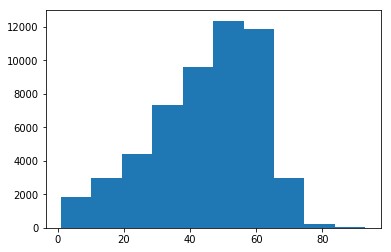

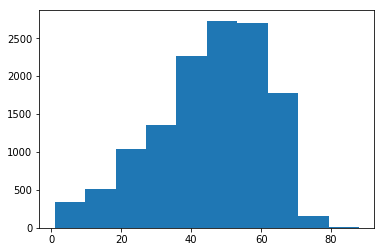

In [21]:
# b. Continous Variable

## 1.Service Billed Duration

bin1 = [MCR_Inscope_All['service_billed_dur'].min()-1,90,180,MCR_Inscope_All['service_billed_dur'].max()+1]
MCR_Inscope_All['service_billed_dur_bin'] = pd.cut(MCR_Inscope_All['service_billed_dur'], bin1)

## 2. Member Age

import matplotlib.pyplot as plt
plt.hist(MCR_Inscope_All.mem_age)
plt.show()

plt.hist(MCR_Inscope_den.mem_age)
plt.show()

bin2 = [MCR_Inscope_All['mem_age'].min()-1,40,60,MCR_Inscope_All['mem_age'].max()+1]
MCR_Inscope_All['mem_age_bin'] = pd.cut(MCR_Inscope_All['mem_age'], bin2)




In [22]:
MCR_Inscope_All['mem_age'].max()+1

94.0

In [23]:
##6. ******CPT

# MCR_Inscope_den1=MCR_Inscope_den[MCR_Inscope_den['proc_cd_gal'] != 'E1399']
# MCR_Inscope_den_cpt=MCR_Inscope_den1.groupby('proc_cd_gal',as_index=False).agg({"clm_10":"count"})
# df_2 = MCR_Inscope_den_cpt.sort_values(by="clm_10",axis=0,ascending=False)
# df_2 = df_2.reset_index(drop=True)
# df_2["cum_sum"] = df_2.clm_10.cumsum()
# df_2["cum_per"] = 100*df_2.cum_sum/df_2.clm_10.sum()
# df_2[df_2["cum_per"]<=80]["proc_cd_gal"]
# name6= df_2[df_2["cum_per"]<=80]["proc_cd_gal"]
# type(name6)
# name6=list(name6)
# name6.extend(['E1399'])

namecpt=['95999','81599','E1399','84999','64999','29999','99199','49999','76496','92700','A0999','43999','46999','27599']

MCR_Inscope_All['proc_cd_gal_bin'] = MCR_Inscope_All.proc_cd_gal.where(MCR_Inscope_All.proc_cd_gal.isin(namecpt), 'others')
print (len(MCR_Inscope_All['proc_cd_gal'].unique()))
print (MCR_Inscope_All['proc_cd_gal_bin'].unique())

125
['others' u'29999' u'64999' u'E1399' u'27599' u'81599' u'43999' u'95999'
 u'46999' u'84999' u'A0999' u'99199' u'49999' u'76496' u'92700']


In [24]:
MCR_Inscope_All['prov_hist_same_06_s']=(MCR_Inscope_All['prov_hist_same_06']-MCR_Inscope_All['prov_hist_same_06'].min())/(MCR_Inscope_All['prov_hist_same_06'].max()-MCR_Inscope_All['prov_hist_same_06'].min())


MCR_Inscope_All['prov_same_cpt_den_rate_bin']=np.where(MCR_Inscope_All['prov_hist_same_06_prop'].isnull(), "NoHistory_3",
                                             np.where(MCR_Inscope_All['prov_hist_same_06_prop']<0.125,"[0-0.125]",
                                                      np.where(MCR_Inscope_All['prov_hist_same_06_prop']>=0.125,"[0.125-1]","Other")))
MCR_Inscope_All['prov_same_cpt_den_rate_bin'].unique()

array(['[0-0.125]', 'NoHistory_3', '[0.125-1]'], dtype=object)

# Model Development

In [25]:

#dev=MCR_Inscope_All[['proc_cd_gal_bin','st_abbr_cd_bin','den_flag_mcr','prov_spcl_catgy_desc_bin','prov_hist_same_06','diag_cat_bin','prop_billed_exceed_med','tin_flag','mem_age_bin','service_billed_dur_bin','cpt_variation_tagging']]
#dev.dtypes
#dev.to_csv('/mapr/projects/MCR_Threshold/Data/all_inscope_dev_m.csv',index=False)

dev=MCR_Inscope_All[['proc_cd_gal_bin','prov_same_cpt_den_rate_bin','st_abbr_cd_bin','den_flag_mcr','prov_hist_same_06_s','diag_cat_bin','service_billed_dur_bin']]


In [26]:
df_d=pd.get_dummies(dev)
#print df_d.columns


X=df_d.drop('den_flag_mcr',axis=1)
X.shape
y=df_d['den_flag_mcr'].values
y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=9)

In [27]:
rf= RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [28]:
print (X_train.shape)
print (y_train.shape)
y_pred = rf.predict(X_train)


# Evaluation train
print(y_pred.shape)
print(classification_report(y_train,y_pred))
print(confusion_matrix(y_train,y_pred))
print('Score: ', rf.score(X_train, y_train))

(37522, 37)
(37522,)
(37522,)
             precision    recall  f1-score   support

          0       0.91      0.85      0.88     28544
          1       0.61      0.73      0.66      8978

avg / total       0.84      0.82      0.83     37522

[[24259  4285]
 [ 2404  6574]]
('Score: ', 0.82173125099941369)


In [29]:
# Evaluation validate

y_pred = rf.predict(X_test)
print(y_pred.shape)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

(16082,)
             precision    recall  f1-score   support

          0       0.87      0.83      0.85     12159
          1       0.54      0.63      0.58      3923

avg / total       0.79      0.78      0.79     16082

[[10075  2084]
 [ 1455  2468]]


In [30]:
imp=rf.feature_importances_
names=X.columns.values
imp,names=zip(*sorted(zip(imp,names)))

df_1=pd.DataFrame({"Variable":names,"importance":imp})
df_2 = df_1.sort_values(by="importance",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)
df_2["cum_sum"] = df_2.importance.cumsum()
df_2["cum_per"] = 100*df_2.cum_sum/df_2.importance.sum()
df_2
#df_2.to_csv('/mapr/projects/MCR_Threshold/Data/dummy_imp_dev.csv',index=False)

,Variable,importance,cum_sum,cum_per
0,prov_hist_same_06_s,0.274390,0.274390,27.439011
1,prov_same_cpt_den_rate_bin_[0.125-1],0.149391,0.423781,42.378126
2,prov_same_cpt_den_rate_bin_[0-0.125],0.092109,0.515891,51.589050
3,proc_cd_gal_bin_others,0.088141,0.604032,60.403157
4,proc_cd_gal_bin_95999,0.079647,0.683679,68.367872
5,st_abbr_cd_bin_TX,0.028105,0.711784,71.178403
6,diag_cat_bin_MUSCULO,0.023325,0.735109,73.510862
7,"service_billed_dur_bin_(-1.0, 90.0]",0.020290,0.755399,75.539911
8,st_abbr_cd_bin_others,0.019504,0.774903,77.490349
9,prov_same_cpt_den_rate_bin_NoHistory_3,0.017797,0.792701,79.270068


In [31]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 20)       
rfe = rfe.fit(X_train,y_train)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking
col = X_train.columns[rfe.support_]
col


[ True  True  True  True  True False False False  True False  True  True
 False  True  True  True  True  True  True  True False  True False False
  True False False False False  True  True False False False  True False
 False]
[ 1  1  1  1  1  4 10  2  1 14  1  1 15  1  1  1  1  1  1  1 18  1  8  6  1
 17 11  7  3  1  1 16 13  9  1  5 12]


Index([                   u'prov_hist_same_06_s',
                        u'proc_cd_gal_bin_27599',
                        u'proc_cd_gal_bin_29999',
                        u'proc_cd_gal_bin_43999',
                        u'proc_cd_gal_bin_46999',
                        u'proc_cd_gal_bin_81599',
                        u'proc_cd_gal_bin_92700',
                        u'proc_cd_gal_bin_95999',
                        u'proc_cd_gal_bin_A0999',
                        u'proc_cd_gal_bin_E1399',
                       u'proc_cd_gal_bin_others',
       u'prov_same_cpt_den_rate_bin_NoHistory_3',
         u'prov_same_cpt_den_rate_bin_[0-0.125]',
         u'prov_same_cpt_den_rate_bin_[0.125-1]',
                            u'st_abbr_cd_bin_AZ',
                            u'st_abbr_cd_bin_DE',
                            u'st_abbr_cd_bin_OK',
                          u'diag_cat_bin_INJURY',
                         u'diag_cat_bin_MUSCULO',
          u'service_billed_dur_bin_(-1.0, 90.0]'],

In [32]:
#feature_imp=pd.read_csv("/mapr/projects/MCR_Threshold/Data/dummy_imp_dev.csv")
name = df_2[df_2["cum_per"]<=80]["Variable"]

#name=np.append(name, ['den_flag_mcr'])
name=np.append(col, ['den_flag_mcr'])

df_d=df_d[name]
X=df_d.drop('den_flag_mcr',axis=1).values
X.shape
y=df_d['den_flag_mcr'].values
y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=9)

In [33]:
rf= RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [34]:

y_pred = rf.predict(X_train)


# Evaluation train
print(y_pred.shape)
print(classification_report(y_train,y_pred))
print(confusion_matrix(y_train,y_pred))
print('Score: ', rf.score(X_train, y_train))

# Evaluation validate

y_pred = rf.predict(X_test)
print(y_pred.shape)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

(37522,)
             precision    recall  f1-score   support

          0       0.90      0.82      0.86     28544
          1       0.55      0.70      0.62      8978

avg / total       0.81      0.79      0.80     37522

[[23413  5131]
 [ 2706  6272]]
('Score: ', 0.79113586695805127)
(16082,)
             precision    recall  f1-score   support

          0       0.88      0.81      0.85     12159
          1       0.53      0.66      0.59      3923

avg / total       0.80      0.78      0.78     16082

[[9888 2271]
 [1343 2580]]


# Hyper Parameter Tuning

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

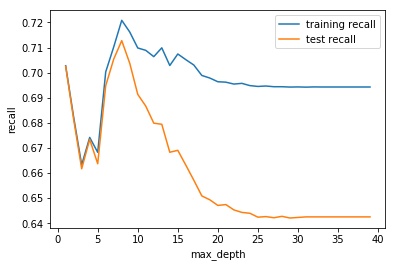

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/app_2/jupyter/anaconda3/

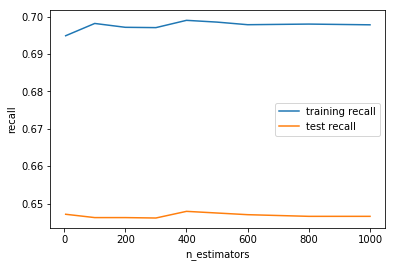

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

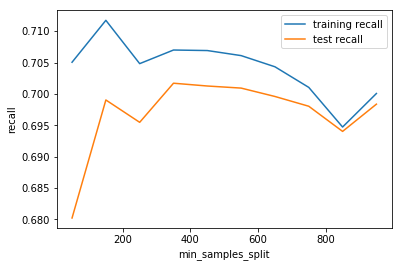

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/app_2/jupyter/anaconda3/lib/python3

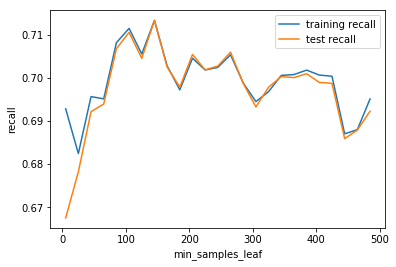

In [187]:
########## lets tune hyper parameterss   
# GridSearchCV to find optimal max_depth   
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = RandomForestClassifier(class_weight='balanced', random_state = 42)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="recall")
tree.fit(X_train,y_train)

# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("recall")
plt.legend()
plt.show()


# specify number of folds for k-fold CV  100 150
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators':  [5,100,200,300,400,500,600,800,1000]}

# instantiate the model
dtree = RandomForestClassifier(class_weight='balanced', random_state = 42)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="recall")
tree.fit(X_train,y_train)

# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("n_estimators")
plt.ylabel("recall")
plt.legend()
plt.show()

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split' : range(50, 1000, 100)}

# instantiate the model
dtree = RandomForestClassifier(class_weight='balanced', random_state = 42)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="recall")
tree.fit(X_train,y_train)

# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("min_samples_split")
plt.ylabel("recall")
plt.legend()
plt.show()

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 500, 20)}

# instantiate the model
dtree = RandomForestClassifier(class_weight='balanced', random_state = 42)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="recall")
tree.fit(X_train,y_train)

# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("min_samples_leaf")
plt.ylabel("recall")
plt.legend()
plt.show()

# Grid Search CV to find best parameters

In [188]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [6,8,9],
    'max_features': ['sqrt',3,4,5],
    'min_samples_leaf': range(100, 150, 10),
    'min_samples_split':  range(400, 600, 100),
    'n_estimators': [ 500,800,1200],
    'class_weight':['balanced'],
    'random_state':[42]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2,scoring='recall')

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 11.3min finished


{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 100,
 'min_samples_split': 500,
 'n_estimators': 500,
 'random_state': 42}

In [35]:
rf= RandomForestClassifier(n_estimators=500,class_weight="balanced",random_state=42,bootstrap=False,max_depth=6,max_features=3,min_samples_leaf=100,min_samples_split=500)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=6, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=500, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

# Performance- Training & Validation

In [36]:

y_pred = rf.predict(X_train)


# Evaluation train
print(y_pred.shape)
print(classification_report(y_train,y_pred))
print(confusion_matrix(y_train,y_pred))
print('Score: ', rf.score(X_train, y_train))

# Evaluation validate

y_pred = rf.predict(X_test)
print(y_pred.shape)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

(37522,)
             precision    recall  f1-score   support

          0       0.90      0.75      0.82     28544
          1       0.48      0.72      0.58      8978

avg / total       0.80      0.75      0.76     37522

[[21495  7049]
 [ 2483  6495]]
('Score: ', 0.74596236874367039)
(16082,)
             precision    recall  f1-score   support

          0       0.89      0.75      0.82     12159
          1       0.48      0.72      0.58      3923

avg / total       0.79      0.74      0.76     16082

[[9149 3010]
 [1091 2832]]


# Lift Decile Analysis- Decide Cutoff

In [37]:
## Lift Decile analysis

y_pred_prob_1 = rf.predict_proba(X_test)[:,1]

data_n=pd.DataFrame({"actual":y_test,"pred":y_pred_prob_1})
data_lift_analysis=data_n.copy()
data_lift_analysis.to_csv("/home/hattri10/lift_all_inscope_final.csv",index=False)


In [38]:
## Applying threshold In sample Validation


threshold=0.3

c=[]

for i in data_n['pred']:
    
    if i > threshold:
        d=[1]
        c.extend(d)
      
    else:
        d=[0]
        c.extend(d)
        
data_n['pred1']=c


# Print confusion Matrix
from sklearn.metrics import confusion_matrix
print (confusion_matrix(data_n['actual'], data_n['pred1']))
print(classification_report(data_n['actual'], data_n['pred1']))


[[5705 6454]
 [ 468 3455]]
             precision    recall  f1-score   support

          0       0.92      0.47      0.62     12159
          1       0.35      0.88      0.50      3923

avg / total       0.78      0.57      0.59     16082



# Out of Sample Testing

# Importing data

In [193]:
### Test out of sample
conn = hive.connect(host='dbslp0500', port= 10002, auth='LDAP', username="hattri10", password="Him<8349")
stat = """set mapreduce.job.queuename= araadh_q1.ararest_sq1"""
stat1="""select * from mcr_eni_redev.test_Apr_may_2019"""
stat1=stat1.replace("\n"," ")
stat1=stat1.replace('\t'," ")
stat1=stat1.replace("   "," ")
cur = conn.cursor()
start=time.time()
print(start)
cur = conn.cursor()
cur.execute(stat)
cur.execute(stat1)
MCR_Inscope= pd.DataFrame(cur.fetchall())
MCR_Inscope.columns = ['key','clm_10','fst_srvc_dt','proc_cd_gal','npi','prov_tin','src_chrg_amt','bth_dt','st_abbr_cd','srvc_prov_catgy_cd','bil_recv_dt','proc_cat','proc_sub_cat','den_flag_mcr','prop_billed_exceed_med','cpt_variation_tagging','service_billed_dur','mem_age','diag_cat','prov_hist_same_03','prov_hist_same_03_prop','prov_hist_same_06','prov_hist_same_06_prop','prov_hist_same_09','prov_hist_same_09_prop','catgy_rol_up_1_desc','catgy_rol_up_2_desc','catgy_rol_up_3_desc','catgy_rol_up_4_desc','prov_catgy_desc','prov_spcl_catgy_desc','ahrq_proc_genl_catgy_desc','prov_spcl_catgy_cd']
print("done")

1562580530.9221742
done


In [194]:
MCR_Inscope.head()

,key,clm_10,fst_srvc_dt,proc_cd_gal,npi,prov_tin,src_chrg_amt,bth_dt,st_abbr_cd,srvc_prov_catgy_cd,...,prov_hist_same_09,prov_hist_same_09_prop,catgy_rol_up_1_desc,catgy_rol_up_2_desc,catgy_rol_up_3_desc,catgy_rol_up_4_desc,prov_catgy_desc,prov_spcl_catgy_desc,ahrq_proc_genl_catgy_desc,prov_spcl_catgy_cd
0,757679927001-5-95999-2018-07-09,7576799270,2018-07-09,95999,1851821193,821548769,7500.0,1970-05-04,CA,0611,...,17,0.708333,NEUROLOGY ...,SPECIALIST,PHYSICIAN,PROFESSIONAL,NEUROLOGIST ...,NEUROLOGIST ...,OPERATIONS NERVOUS SYS,5
1,762673690601-2-89240-2019-01-18,7626736906,2019-01-18,89240,1235417288,264572436,2804.0,1972-06-13,IL,0001,...,0,NaN,GENERAL ACUTE-CARE HOSPITAL ...,ACUTE-CARE HOSPITALS,HOSPITAL,FACILITY,GENERAL HOSPITAL ...,FAMILY PRACTICE/CLINIC ...,MISC DIAG THERAPEUTIC,0
2,762673690601-3-96549-2019-01-18,7626736906,2019-01-18,96549,1235417288,264572436,1154.0,1972-06-13,IL,0001,...,0,NaN,GENERAL ACUTE-CARE HOSPITAL ...,ACUTE-CARE HOSPITALS,HOSPITAL,FACILITY,GENERAL HOSPITAL ...,FAMILY PRACTICE/CLINIC ...,MISC DIAG THERAPEUTIC,0
3,762673690601-4-76499-2019-01-18,7626736906,2019-01-18,76499,1235417288,264572436,6242.0,1972-06-13,IL,0001,...,0,NaN,GENERAL ACUTE-CARE HOSPITAL ...,ACUTE-CARE HOSPITALS,HOSPITAL,FACILITY,GENERAL HOSPITAL ...,FAMILY PRACTICE/CLINIC ...,MISC DIAG THERAPEUTIC,0
4,767254018603-1-29999-2019-02-08,7672540186,2019-02-08,29999,1669694394,113446012,4000.0,1961-03-10,NY,0644,...,0,0.000000,ORTHOPEDICS ...,SPECIALIST,PHYSICIAN,PROFESSIONAL,ORTHOPEDIC SURGEON ...,ORTHOPEDIST ...,OPER MUSCULOSKELETAL SYS,9


In [195]:
MCR_Inscope_oos=MCR_Inscope.copy()
#MCR_Inscope_oos.to_csv("/mapr/projects/MCR_Threshold/Data/MCR_scoring_file_10_09-19_2018.csv",index=False)

In [196]:
MCR_Inscope_train.dtypes

key                           object
clm_10                        object
fst_srvc_dt                   object
proc_cd_gal                   object
npi                           object
prov_tin                      object
src_chrg_amt                 float64
bth_dt                        object
st_abbr_cd                    object
srvc_prov_catgy_cd            object
bil_recv_dt                   object
proc_cat                      object
proc_sub_cat                  object
den_flag_mcr                   int64
prop_billed_exceed_med       float64
cpt_variation_tagging          int64
service_billed_dur             int64
mem_age                      float64
diag_cat                      object
prov_hist_same_03              int64
prov_hist_same_03_prop       float64
prov_hist_same_06              int64
prov_hist_same_06_prop       float64
prov_hist_same_09              int64
prov_hist_same_09_prop       float64
catgy_rol_up_1_desc           object
catgy_rol_up_2_desc           object
c

# Data Preparation


In [197]:
## Concatenating train & test
MCR_Inscope_train['check']='Development'
MCR_Inscope_oos['check']='Out_of_sample'

col=['check','clm_10','fst_srvc_dt','proc_cd_gal','npi','prov_tin','src_chrg_amt','bth_dt','prov_spcl_catgy_desc','st_abbr_cd','srvc_prov_catgy_cd','bil_recv_dt','proc_cat','proc_sub_cat','den_flag_mcr','prop_billed_exceed_med','cpt_variation_tagging','service_billed_dur','mem_age','diag_cat','prov_hist_same_06','prov_hist_same_06_prop']
MCR_Inscope_train=MCR_Inscope_train[col]
MCR_Inscope_oos=MCR_Inscope_oos[col]


frames = [MCR_Inscope_train, MCR_Inscope_oos]
Final = pd.concat(frames)


MCR_Inscope_All=Final.drop_duplicates().reset_index(drop=True)



In [198]:

MCR_Inscope_All.drop_duplicates(inplace=True)
#MCR_Inscope_All.drop(['npi','bth_dt','812462824_tin_flag'], axis=1, inplace=True)
MCR_Inscope_All.reset_index()
print (MCR_Inscope.shape,MCR_Inscope_All.shape)

MCR_Inscope_All.head(2)

(7827, 33) (59535, 22)


,check,clm_10,fst_srvc_dt,proc_cd_gal,npi,prov_tin,src_chrg_amt,bth_dt,prov_spcl_catgy_desc,st_abbr_cd,...,proc_cat,proc_sub_cat,den_flag_mcr,prop_billed_exceed_med,cpt_variation_tagging,service_billed_dur,mem_age,diag_cat,prov_hist_same_06,prov_hist_same_06_prop
0,Development,3328641134,2017-12-28,55899,1053346064,620858347,4000.0,1955-09-02,UROLOGIST ...,ME,...,Unlisted,surgical,0,1.000000,1,5,64.0,NEOPLASMS,0,0.0
1,Development,3328643764,2017-12-22,69799,1730126392,391127163,4326.0,1985-10-12,OTOLARYNGOLOGIST ...,ME,...,Unlisted,surgical,0,0.909091,1,11,34.0,NERVOUS,0,0.0


In [199]:
# strip (whitespaces) all object dtypes
df_obj = MCR_Inscope_All.select_dtypes(['object'])
df_obj
MCR_Inscope_All[df_obj.columns] = df_obj.apply(lambda x: x.str.strip()).replace('', np.nan)
del [[df_obj]];df_obj = pd.DataFrame();

In [200]:
#Dates {infer_datetime_format=True}
#MCR_Inscope_All['fst_srvc_dt']=MCR_Inscope_All['fst_srvc_dt'].astype(str).str.strip()
#MCR_Inscope_All['fst_srvc_dt']=pd.to_datetime(MCR_Inscope_All['fst_srvc_dt'], format = "%Y-%m-%d")
#MCR_Inscope_All['lst_srvc_dt']=pd.to_datetime(MCR_Inscope_All['lst_srvc_dt'], format = "%Y-%m-%d")
#MCR_Inscope_All['bil_recv_dt']=pd.to_datetime(MCR_Inscope_All['bil_recv_dt'], format = "%Y-%m-%d")
MCR_Inscope_All['cpt_variation_tagging']=MCR_Inscope_All['cpt_variation_tagging'].astype(str)
#MCR_Inscope_All['den_flag_mcr']=MCR_Inscope_All['den_flag_mcr'].astype(str)


In [201]:
#missing value imputation (Mode)
cols_cat = ['st_abbr_cd','prov_spcl_catgy_desc','diag_cat']
MCR_Inscope_All[cols_cat]=MCR_Inscope_All[cols_cat].fillna(MCR_Inscope_All_use.mode().iloc[0])
#MCR_Inscope_All['prov_gndr']=MCR_Inscope_All['prov_gndr'].replace("U",MCR_Inscope_All_use['prov_gndr'].mode().iloc[0])

In [202]:
#missing value imputation (median)
#df.apply(lambda x: x.fillna(x.mean()),axis=0)
cols_conti = ['service_billed_dur','mem_age','prop_billed_exceed_med']
MCR_Inscope_All[cols_conti]=MCR_Inscope_All[cols_conti].fillna((MCR_Inscope_All_use[cols_conti].median()))

In [203]:
#Outlier Treatment
MCR_Inscope_All["mem_age"] = np.where(MCR_Inscope_All["mem_age"] < 0,
                                      MCR_Inscope_All_use['mem_age'].median(),
                                      np.where(MCR_Inscope_All['mem_age'] == 0,
                                               1,
                                               np.where(MCR_Inscope_All['mem_age']> MCR_Inscope_All_use['mem_age'].max(),
                                                        MCR_Inscope_All_use['mem_age'].max(),
                                                        MCR_Inscope_All['mem_age'])))


MCR_Inscope_All['service_billed_dur'] = np.where(MCR_Inscope_All['service_billed_dur'] < 0,
                                                 MCR_Inscope_All_use['service_billed_dur'].median(),
                                                 np.where(MCR_Inscope_All['service_billed_dur']>MCR_Inscope_All_use['service_billed_dur'].max(),
                                                          MCR_Inscope_All_use['service_billed_dur'].max(),
                                                          MCR_Inscope_All['service_billed_dur']
                                                         ))###bucketing for service billed duration 90-180 , above 180 
#q99=MCR_Inscope_All_use['provider_tenure'].quantile(0.995)
#MCR_Inscope_All['provider_tenure'] = np.where(MCR_Inscope_All['provider_tenure'] < 0,MCR_Inscope_All_use['provider_tenure'].median(),np.where(MCR_Inscope_All['provider_tenure'] > q99,q99,MCR_Inscope_All['provider_tenure']))

#q90_03=MCR_Inscope_All_use['prov_hist_same_03'].quantile(0.90)
#MCR_Inscope_All['prov_hist_same_03'] = np.where(MCR_Inscope_All['prov_hist_same_03'] > q90_03, q90_03, MCR_Inscope_All['prov_hist_same_03'])

q90_06=MCR_Inscope_All_use['prov_hist_same_06'].quantile(0.90)
MCR_Inscope_All['prov_hist_same_06'] = np.where(MCR_Inscope_All['prov_hist_same_06'] > q90_06, q90_06, MCR_Inscope_All['prov_hist_same_06'])

#q90_09=MCR_Inscope_All_use['prov_hist_same_09'].quantile(0.90)
#MCR_Inscope_All['prov_hist_same_09'] = np.where(MCR_Inscope_All['prov_hist_same_09'] > q90_09, q90_09, MCR_Inscope_All['prov_hist_same_09'])                                        

In [204]:
# Variable Bucketization
# a.Categorical variables

## 1.Diagnosis code category


MCR_Inscope_All['diag_cat_bin'] = MCR_Inscope_All.diag_cat.where(MCR_Inscope_All.diag_cat.isin(name1), 'others')
print(MCR_Inscope_All['diag_cat_bin'].unique())

## 2.Provider State category

MCR_Inscope_All['st_abbr_cd_bin'] = MCR_Inscope_All.st_abbr_cd.where(MCR_Inscope_All.st_abbr_cd.isin(name2), 'others')
print(MCR_Inscope_All['st_abbr_cd_bin'].unique())

##3.CPT high level description

#MCR_Inscope_All['ahrq_proc_genl_catgy_desc_bin'] = MCR_Inscope_All.ahrq_proc_genl_catgy_desc.where(MCR_Inscope_All.ahrq_proc_genl_catgy_desc.isin(name3), 'others')
#MCR_Inscope_All['ahrq_proc_genl_catgy_desc_bin'].unique()

##4.catgy_rol_up_2_desc servicing provider catgy code high level description

#MCR_Inscope_All['catgy_rol_up_2_desc_bin'] = MCR_Inscope_All.catgy_rol_up_2_desc.where(MCR_Inscope_All.catgy_rol_up_2_desc.isin(name4), 'others')
#MCR_Inscope_All['catgy_rol_up_2_desc_bin'].unique()

##5.Speciality code high level description

MCR_Inscope_All['prov_spcl_catgy_desc_bin'] = MCR_Inscope_All.prov_spcl_catgy_desc.where(MCR_Inscope_All.prov_spcl_catgy_desc.isin(name5), 'others')
print(MCR_Inscope_All['prov_spcl_catgy_desc_bin'].unique())

##6 tin flag
MCR_Inscope_All['tin_flag'] = MCR_Inscope_All.prov_tin.where(MCR_Inscope_All.prov_tin.isin(name6), 'others')



['NEOPLASMS' 'NERVOUS' 'MUSCULO' 'INJURY' 'DIGESTIVE' 'others']
['others' 'TX' 'OK' 'IL' 'CA' 'AZ' 'WI' 'OH' 'DE']
['others' 'ORTHOPEDIST' 'SURGEON' 'FAMILY PRACTICE/CLINIC'
 'FAMILY PRACTICE' 'OTHER' 'NEUROLOGIST' 'ANESTHESIOLOGIST' 'RADIOLOGIST']


In [205]:
# b. Continous Variable

## 1.Service Billed Duration


MCR_Inscope_All['service_billed_dur_bin'] = pd.cut(MCR_Inscope_All['service_billed_dur'], bin1)

## 2. Member Age


MCR_Inscope_All['mem_age_bin'] = pd.cut(MCR_Inscope_All['mem_age'], bin2)


## 3. Provider Tenure

#bin3 = [MCR_Inscope_All['provider_tenure'].min()-1,5,MCR_Inscope_All['provider_tenure'].max()+1]
#MCR_Inscope_All['provider_tenure_bin'] = pd.cut(MCR_Inscope_All['provider_tenure'], bin3)



In [206]:
##6. ******CPT


MCR_Inscope_All['proc_cd_gal_bin'] = MCR_Inscope_All.proc_cd_gal.where(MCR_Inscope_All.proc_cd_gal.isin(namecpt), 'others')
MCR_Inscope_All['proc_cd_gal_bin'].unique()

array(['others', '29999', '64999', 'E1399', '27599', '81599', '43999',
       '95999', '46999', '84999', 'A0999', '99199', '49999', '76496',
       '92700'], dtype=object)

In [207]:
MCR_Inscope_All['prov_hist_same_06_s']=(MCR_Inscope_All['prov_hist_same_06']-MCR_Inscope_All_use['prov_hist_same_06'].min())/(MCR_Inscope_All_use['prov_hist_same_06'].max()-MCR_Inscope_All_use['prov_hist_same_06'].min())


MCR_Inscope_All['prov_same_cpt_den_rate_bin']=np.where(MCR_Inscope_All['prov_hist_same_06_prop'].isnull(), "NoHistory_3",
                                             np.where(MCR_Inscope_All['prov_hist_same_06_prop']<0.125,"[0-0.125]",
                                                      np.where(MCR_Inscope_All['prov_hist_same_06_prop']>=0.125,"[0.125-1]","Other")))
MCR_Inscope_All['prov_same_cpt_den_rate_bin'].unique()

array(['[0-0.125]', 'NoHistory_3', '[0.125-1]'], dtype=object)

In [208]:
#MCR_Inscope_All.to_csv("/mapr/projects/MCR_Threshold/Data/Inscope_develpmnt_outofsamp.csv",index=False)

In [209]:
dev=MCR_Inscope_All[['proc_cd_gal_bin','prov_same_cpt_den_rate_bin','st_abbr_cd_bin','den_flag_mcr','prov_hist_same_06_s','diag_cat_bin','service_billed_dur_bin']]


In [210]:
MCR_Inscope_All.check.unique()

array(['Development', 'Out_of_sample'], dtype=object)

# Scoring using model developed

In [211]:

df_d=pd.get_dummies(dev)
df_d=df_d[name]
X=df_d.drop('den_flag_mcr',axis=1)

print( X.shape)
y=df_d['den_flag_mcr'].values
print (y.shape)



### Separating out of sample
y_pred = rf.predict(X)
y_prob=rf.predict_proba(X)[:,1]
MCR_Inscope_All['pred']=y_pred
MCR_Inscope_All['pred_proba']=y_prob
data_oos=MCR_Inscope_All[MCR_Inscope_All['check']=='Out_of_sample']

##out of sample results

print(classification_report(data_oos['den_flag_mcr'],data_oos['pred']))
print(confusion_matrix(data_oos['den_flag_mcr'],data_oos['pred']))

type(data_oos)

(59535, 20)
(59535,)
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      5487
           1       0.56      0.78      0.65      2152

   micro avg       0.76      0.76      0.76      7639
   macro avg       0.73      0.77      0.74      7639
weighted avg       0.80      0.76      0.77      7639

[[4159 1328]
 [ 478 1674]]


pandas.core.frame.DataFrame

# Performance

In [157]:

## Applying threshold

threshold=0.3

c=[]

for i in data_oos['pred_proba']:
    
    if i > threshold:
        d=[1]
        c.extend(d)
      
    else:
        d=[0]
        c.extend(d)
        
data_oos['pred1']=c


# Print confusion Matrix
from sklearn.metrics import confusion_matrix

print(classification_report(data_oos['den_flag_mcr'], data_oos['pred1']))
print(confusion_matrix(data_oos['den_flag_mcr'], data_oos['pred1']))



              precision    recall  f1-score   support

           0       0.94      0.44      0.59      5487
           1       0.39      0.93      0.55      2152

   micro avg       0.57      0.57      0.57      7639
   macro avg       0.67      0.68      0.57      7639
weighted avg       0.79      0.57      0.58      7639

[[2387 3100]
 [ 154 1998]]


/app_2/jupyter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [226]:
data_oos.head()
data_oos.to_csv("/home/hattri10/oos_inscope_All_final.csv",index=False)


In [227]:
data_oos.head()

,check,clm_10,fst_srvc_dt,proc_cd_gal,npi,prov_tin,src_chrg_amt,bth_dt,prov_spcl_catgy_desc,st_abbr_cd,...,prov_spcl_catgy_desc_bin,tin_flag,service_billed_dur_bin,mem_age_bin,proc_cd_gal_bin,prov_hist_same_06_s,prov_same_cpt_den_rate_bin,pred,pred_proba,pred1
51896,Out_of_sample,7576799270,2018-07-09,95999,1851821193,821548769,7500.0,1970-05-04,NEUROLOGIST,CA,...,NEUROLOGIST,others,"(90.0, 180.0]","(40.0, 60.0]",95999,0.02807,[0.125-1],1,0.827844,1
51897,Out_of_sample,7626736906,2019-01-18,89240,1235417288,264572436,2804.0,1972-06-13,FAMILY PRACTICE/CLINIC,IL,...,FAMILY PRACTICE/CLINIC,others,"(-1.0, 90.0]","(40.0, 60.0]",others,0.00000,NoHistory_3,0,0.238904,0
51898,Out_of_sample,7626736906,2019-01-18,96549,1235417288,264572436,1154.0,1972-06-13,FAMILY PRACTICE/CLINIC,IL,...,FAMILY PRACTICE/CLINIC,others,"(-1.0, 90.0]","(40.0, 60.0]",others,0.00000,NoHistory_3,0,0.238904,0
51899,Out_of_sample,7626736906,2019-01-18,76499,1235417288,264572436,6242.0,1972-06-13,FAMILY PRACTICE/CLINIC,IL,...,FAMILY PRACTICE/CLINIC,others,"(-1.0, 90.0]","(40.0, 60.0]",others,0.00000,NoHistory_3,0,0.238904,0
51900,Out_of_sample,7672540186,2019-02-08,29999,1669694394,113446012,4000.0,1961-03-10,ORTHOPEDIST,NY,...,ORTHOPEDIST,others,"(-1.0, 90.0]","(40.0, 60.0]",29999,0.00000,NoHistory_3,0,0.359173,1


In [39]:
import pickle
# save the model to disk
filename = 'model_unlisted_inscope.sav'
pickle.dump(rf, open(filename, 'wb'))

In [40]:


# save training data on disk
MCR_Inscope_All_use.to_pickle("./MCR_Inscope_All_use.pkl")

#MCR_Inscope_train.to_pickle("./MCR_Inscope_train.pkl")


In [162]:
MCR_Inscope_train.head()

,check,clm_10,fst_srvc_dt,proc_cd_gal,npi,prov_tin,src_chrg_amt,bth_dt,prov_spcl_catgy_desc,st_abbr_cd,...,proc_cat,proc_sub_cat,den_flag_mcr,prop_billed_exceed_med,cpt_variation_tagging,service_billed_dur,mem_age,diag_cat,prov_hist_same_06,prov_hist_same_06_prop
0,Development,3328641134,2017-12-28,55899,1053346064,620858347,4000.0,1955-09-02,UROLOGIST ...,ME,...,Unlisted,surgical,0,1.000000,1,5,64.0,NEOPLASMS,0,0.0
1,Development,3328643764,2017-12-22,69799,1730126392,391127163,4326.0,1985-10-12,OTOLARYNGOLOGIST ...,ME,...,Unlisted,surgical,0,0.909091,1,11,34.0,NERVOUS,0,0.0
2,Development,3328643764,2017-12-22,69799,1730126392,391127163,2163.0,1985-10-12,OTOLARYNGOLOGIST ...,ME,...,Unlisted,surgical,0,0.909091,1,11,34.0,NERVOUS,0,0.0
3,Development,3328643794,2017-12-18,29999,1417953787,911352993,1129.0,1989-08-14,PODIATRIST/MD ...,ME,...,Unlisted,surgical,0,0.391304,0,15,30.0,MUSCULO,0,NaN
4,Development,3329173492,2017-12-21,29999,1699765107,752507791,2200.0,1990-07-23,ORTHOPEDIST ...,ME,...,Unlisted,surgical,0,0.487805,0,13,29.0,INJURY,0,NaN
